### Make classification data

In [2]:
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

print(f"First 5 X features: \n{X[:5]}")
print(f"First 5 y labels: {y[:5]}")

First 5 X features: 
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 y labels: [1 1 1 1 0]


### Make dataframe of circle data

In [3]:
import pandas as pd

circles = pd.DataFrame({"X1" : X[:, 0],
                        "X2" : X[:, 1],
                        "label" : y})

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


### check the number of each class

In [4]:
circles.label.value_counts()

1    500
0    500
Name: label, dtype: int64

### plot the circles

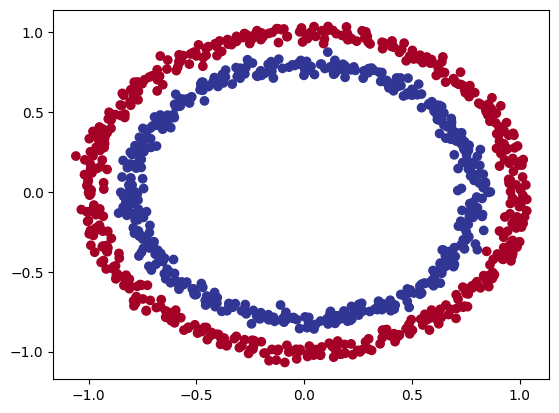

In [5]:
import matplotlib.pyplot as plt
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [6]:
# check the shapes of features and labels
X.shape, y.shape

((1000, 2), (1000,))

In [7]:
# view the value and shape of a single sample
X_sample = X[0]
y_sample = y[0]
print(X_sample, y_sample)
print(X_sample.shape, y_sample.shape)

[0.75424625 0.23148074] 1
(2,) ()


#### ↑two inputs for one output

### Turn the data into tensors

In [8]:
import torch

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
len(X_train), len(X_test), len(y_train), len(y_test)


(800, 200, 800, 200)

### creating a model

In [10]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [11]:
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=5)
    self.layer_2 = nn.Linear(in_features=5, out_features=1)

  def forward(self, x):
    return self.layer_2(self.layer_1(x))

model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

### replicate model_0 using nn.Sequential

In [12]:
model_0 = nn.Sequential(nn.Linear(in_features=2, out_features=5),
                        nn.Linear(in_features=5, out_features=1)).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

### making predictions with the model

In [13]:
# Make predictions with the model
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[0.3748],
        [0.3664],
        [0.4836],
        [0.3436],
        [0.6214],
        [0.6152],
        [0.4824],
        [0.5410],
        [0.4776],
        [0.3674]], device='cuda:0', grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### Creating loss function and optimizer

In [14]:
Loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [15]:
### Creating accuracy function

In [16]:
def accuracy(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = ( correct / len(y_pred) ) * 100
  return acc

### view 5 elements of forward step on test data

In [17]:
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[0.3748],
        [0.3664],
        [0.4836],
        [0.3436],
        [0.6214]], device='cuda:0', grad_fn=<SliceBackward0>)

### use sigmoid on model logits (how much the model thinks it is closer to one or zero)

In [18]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5926],
        [0.5906],
        [0.6186],
        [0.5851],
        [0.6505]], device='cuda:0', grad_fn=<SigmoidBackward0>)

### rounding the prediction probabilities

In [19]:
y_preds = torch.round(y_pred_probs)

y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))))[:5]

print(y_preds.squeeze() == y_pred_labels.squeeze())

y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([1., 1., 1., 1., 1.], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [20]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

### ↑now the prediction and test data are in the same form

### training the model

In [21]:
torch.manual_seed(42)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_0.train()

  # forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # calculate loss and accuracy
  loss = Loss_fn(y_logits, y_train)
  acc = accuracy(y_true=y_train,
                 y_pred=y_pred)

  # zero grad the optimizer
  optimizer.zero_grad()

  # loss backwards
  loss.backward()

  # step the optimizer
  optimizer.step()

  # testing
  model_0.eval()

  with torch.inference_mode():
    # Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # Calculate the loss
    test_loss = Loss_fn(test_logits, y_test)
    test_acc = accuracy(y_true = y_test,
                          y_pred = test_pred)

  # Print out the training state every 10 epochs
  if epoch % 10 == 0:
    print(f"Epochs: {epoch} | Loss: {loss} | Accuracy: {acc} | Test Loss: {test_loss} | Test Accuracy: {test_acc}")



Epochs: 0 | Loss: 0.7251559495925903 | Accuracy: 50.0 | Test Loss: 0.7181276679039001 | Test Accuracy: 50.0
Epochs: 10 | Loss: 0.7041031718254089 | Accuracy: 50.0 | Test Loss: 0.7003480195999146 | Test Accuracy: 50.0
Epochs: 20 | Loss: 0.6970194578170776 | Accuracy: 50.0 | Test Loss: 0.6947212219238281 | Test Accuracy: 50.0
Epochs: 30 | Loss: 0.6946014761924744 | Accuracy: 50.0 | Test Loss: 0.6930989623069763 | Test Accuracy: 50.0
Epochs: 40 | Loss: 0.6937353610992432 | Accuracy: 50.0 | Test Loss: 0.6927651762962341 | Test Accuracy: 50.0
Epochs: 50 | Loss: 0.6933937072753906 | Accuracy: 50.0 | Test Loss: 0.6928304433822632 | Test Accuracy: 50.0
Epochs: 60 | Loss: 0.6932381391525269 | Accuracy: 50.0 | Test Loss: 0.6930063962936401 | Test Accuracy: 50.0
Epochs: 70 | Loss: 0.6931555271148682 | Accuracy: 50.0 | Test Loss: 0.6932008266448975 | Test Accuracy: 50.0
Epochs: 80 | Loss: 0.6931055784225464 | Accuracy: 53.87499999999999 | Test Loss: 0.6933844089508057 | Test Accuracy: 47.0
Epochs:

### import helper functions to visualize predictions and decision boundary

In [22]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)
from helper_functions import plot_predictions, plot_decision_boundary


downloading helper_functions.py


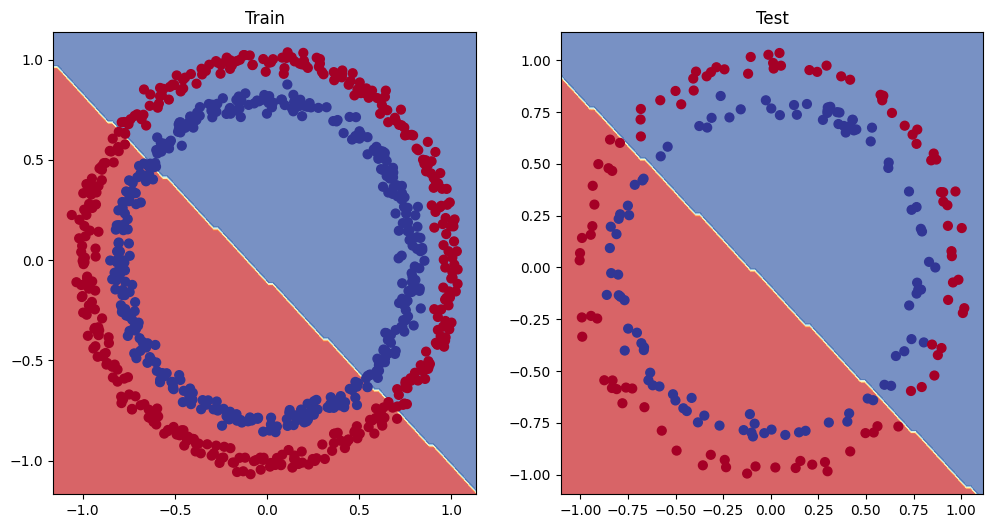

In [23]:
# Plot decision boundaries for training and test sets
plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)


### ↑ Since model_0 is using a straight line to determine, it can only guess 50%

### Adding layers, epochs, and hidden units

In [24]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
  def forward(self, x):
    return self.layer_3( self.layer_2( self.layer_1(x) ) )

model_1 = CircleModelV1()
model_1.to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [25]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = model_1.parameters(), lr=0.1)

In [26]:
torch.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_1.train()

  # Forward pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round( torch.sigmoid( y_logits ) )

  # Calculate loss and accuracy
  loss = loss_fn(y_logits, y_train)
  acc = accuracy(y_true = y_train,
                 y_pred = y_pred)

  # Zero grad the optimizer
  optimizer.zero_grad()

  # Backward propagation on the loss
  loss.backward()

  # Step the optimizer
  optimizer.step()

  # Test the model
  model_1.eval()
  with torch.inference_mode():
    # Forward pass
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round( torch.sigmoid( test_logits ) )

    # Calculate loss and accuracy
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy(y_true=y_test,
                        y_pred=test_pred)

    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss} | Accuracy: {acc} | Test Loss: {test_loss} | Test Accuracy: {test_acc}")



Epoch: 0 | Loss: 0.6939550638198853 | Accuracy: 50.875 | Test Loss: 0.6926146745681763 | Test Accuracy: 51.0
Epoch: 100 | Loss: 0.6930478811264038 | Accuracy: 50.375 | Test Loss: 0.6937904357910156 | Test Accuracy: 48.0
Epoch: 200 | Loss: 0.6929859519004822 | Accuracy: 51.125 | Test Loss: 0.6943727135658264 | Test Accuracy: 46.0
Epoch: 300 | Loss: 0.6929804682731628 | Accuracy: 51.625 | Test Loss: 0.6945767998695374 | Test Accuracy: 45.0
Epoch: 400 | Loss: 0.6929798722267151 | Accuracy: 51.125 | Test Loss: 0.6946452260017395 | Test Accuracy: 46.0
Epoch: 500 | Loss: 0.6929798722267151 | Accuracy: 51.0 | Test Loss: 0.6946680545806885 | Test Accuracy: 46.0
Epoch: 600 | Loss: 0.6929798722267151 | Accuracy: 51.0 | Test Loss: 0.6946756839752197 | Test Accuracy: 46.0
Epoch: 700 | Loss: 0.6929798722267151 | Accuracy: 51.0 | Test Loss: 0.6946782469749451 | Test Accuracy: 46.0
Epoch: 800 | Loss: 0.6929798722267151 | Accuracy: 51.0 | Test Loss: 0.6946790814399719 | Test Accuracy: 46.0
Epoch: 900 

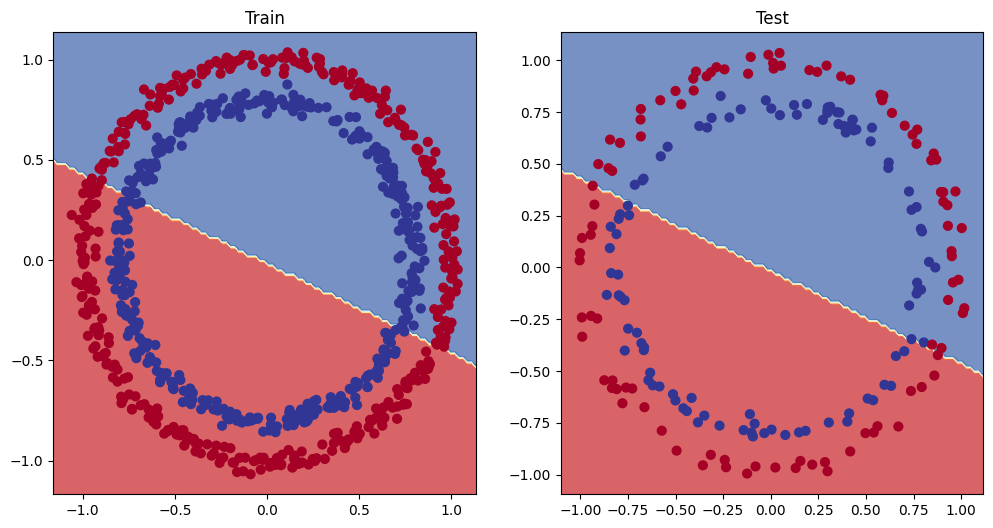

In [27]:
plt.figure( figsize=(12, 6) )
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)


### Preparing data to see if model_1 can model a straight line

In [28]:
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [29]:
train_split = int(0.8 * len(X_regression))

X_train, y_train = X_regression[:train_split], y_regression[:train_split]
X_test, y_test = X_regression[train_split:], y_regression[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(80, 80, 20, 20)

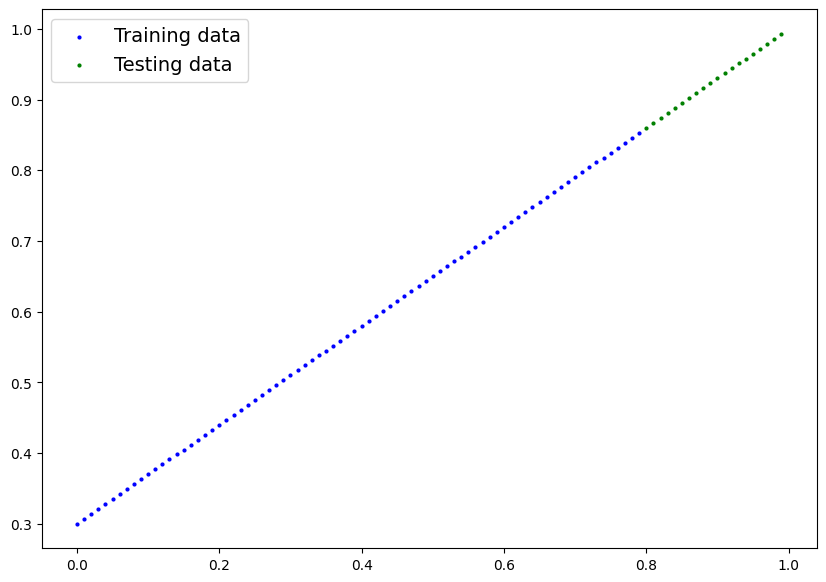

In [30]:
plot_predictions(train_data=X_train,
                 train_labels=y_train,
                 test_data=X_test,
                 test_labels=y_test)

In [31]:
model_2 = nn.Sequential(nn.Linear(in_features=1, out_features=10),
                        nn.Linear(in_features=10, out_features=10),
                        nn.Linear(in_features=10, out_features=1)
                        )
model_2.to(device)
model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [32]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

### Train model_2

In [33]:
torch.manual_seed(42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 1000

for epoch in range(epochs):
  model_2.train()

  y_pred = model_2(X_train)

  loss = loss_fn(y_pred, y_train)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()


  model_2.eval()
  with torch.inference_mode():
    test_pred = model_2(X_test)
    test_loss = loss_fn(test_pred, y_test)
    if epoch % 100 == 0:
      print(f"Epochs: {epoch} | Loss: {loss}| Test Loss: {test_loss}")

Epochs: 0 | Loss: 0.7598585486412048| Test Loss: 0.541427731513977
Epochs: 100 | Loss: 0.09308692812919617| Test Loss: 0.029011724516749382
Epochs: 200 | Loss: 0.07375659793615341| Test Loss: 0.028500476852059364
Epochs: 300 | Loss: 0.06745029240846634| Test Loss: 0.0061517744325101376
Epochs: 400 | Loss: 0.06106658652424812| Test Loss: 0.020038655027747154
Epochs: 500 | Loss: 0.05698131397366524| Test Loss: 0.010606971569359303
Epochs: 600 | Loss: 0.0485655702650547| Test Loss: 0.013262957334518433
Epochs: 700 | Loss: 0.06108519434928894| Test Loss: 0.021267009899020195
Epochs: 800 | Loss: 0.05599264055490494| Test Loss: 0.014256960712373257
Epochs: 900 | Loss: 0.055710047483444214| Test Loss: 0.006033757235854864


### Making predictions with model_2

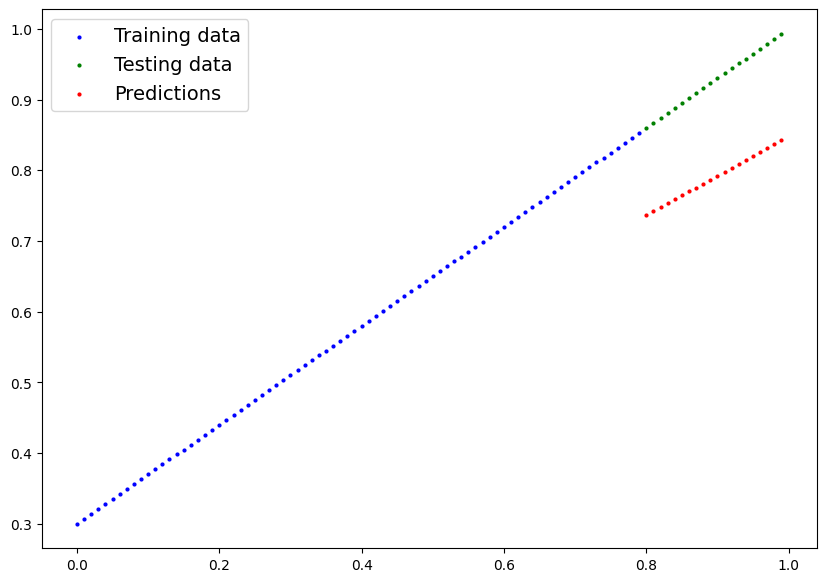

In [34]:
model_2.eval()

with torch.inference_mode():
  y_preds = model_2(X_test)

plot_predictions(train_data=X_train.cpu(),
                    train_labels=y_train.cpu(),
                    test_data=X_test.cpu(),
                    test_labels=y_test.cpu(),
                    predictions=y_preds.cpu())

### Recreating non linear data

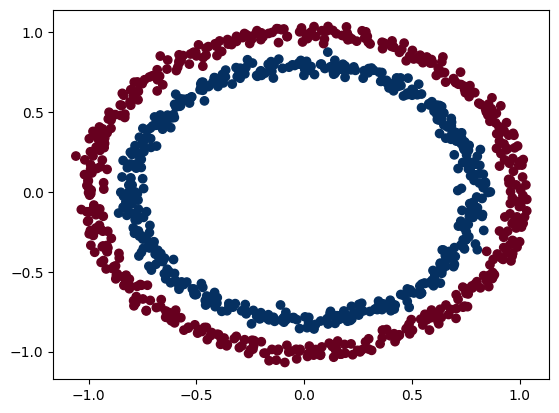

In [35]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n = 1000

X, y = make_circles(n_samples = 1000,
                    noise = 0.03,
                    random_state = 42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap = plt.cm.RdBu)

In [36]:
import torch
from sklearn.model_selection import train_test_split

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train[:5], y_train[:5]


(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### Building a model with non linearity

In [37]:
from torch import nn
class CircleModelV3(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features = 2, out_features = 10)
    self.layer_2 = nn.Linear(in_features = 10, out_features = 10)
    self.layer_3 = nn.Linear(in_features = 10, out_features = 1)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.layer_3( self.relu(self.layer_2(self.relu(self.layer_1(x)))) )

model_3 = CircleModelV3().to(device)
model_3

CircleModelV3(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [38]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

### Train model_3

In [39]:
torch.manual_seed(42)
epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  # train
  # forward pass
  logits = model_3(X_train).squeeze()
  preds = torch.round(torch.sigmoid(logits))

  # calculate loss and accuracy
  loss = loss_fn(logits, y_train)
  acc = accuracy(y_true=y_train,
                 y_pred=preds)

  # zero gradient optimizer
  optimizer.zero_grad()

  # backward propagation on the loss
  loss.backward()

  # step the optimizer
  optimizer.step()

  # test
  model_3.eval()
  with torch.inference_mode():
    # forward pass
    test_logits = model_3(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))

    # calculate loss and accuracy
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy(y_true=y_test,
                        y_pred=test_preds)

    # print out what's happening
    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f} | Accuracy: {acc:.2f} | Test Loss: {test_loss:.5f} | Test Accuracy: {test_acc:.2f}")



Epoch: 0 | Loss: 0.69295 | Accuracy: 50.00 | Test Loss: 0.69319 | Test Accuracy: 50.00
Epoch: 100 | Loss: 0.69115 | Accuracy: 52.88 | Test Loss: 0.69102 | Test Accuracy: 52.50
Epoch: 200 | Loss: 0.68977 | Accuracy: 53.37 | Test Loss: 0.68940 | Test Accuracy: 55.00
Epoch: 300 | Loss: 0.68795 | Accuracy: 53.00 | Test Loss: 0.68723 | Test Accuracy: 56.00
Epoch: 400 | Loss: 0.68517 | Accuracy: 52.75 | Test Loss: 0.68411 | Test Accuracy: 56.50
Epoch: 500 | Loss: 0.68102 | Accuracy: 52.75 | Test Loss: 0.67941 | Test Accuracy: 56.50
Epoch: 600 | Loss: 0.67515 | Accuracy: 54.50 | Test Loss: 0.67285 | Test Accuracy: 56.00
Epoch: 700 | Loss: 0.66659 | Accuracy: 58.38 | Test Loss: 0.66322 | Test Accuracy: 59.00
Epoch: 800 | Loss: 0.65160 | Accuracy: 64.00 | Test Loss: 0.64757 | Test Accuracy: 67.50
Epoch: 900 | Loss: 0.62362 | Accuracy: 74.00 | Test Loss: 0.62145 | Test Accuracy: 79.00


### make predictions with model_3

In [40]:
with torch.inference_mode():
  y_logits = model_3(X_test).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits))

y_preds[:10], y[:10]


(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

### plot decision boundaries of model_1 and model_3

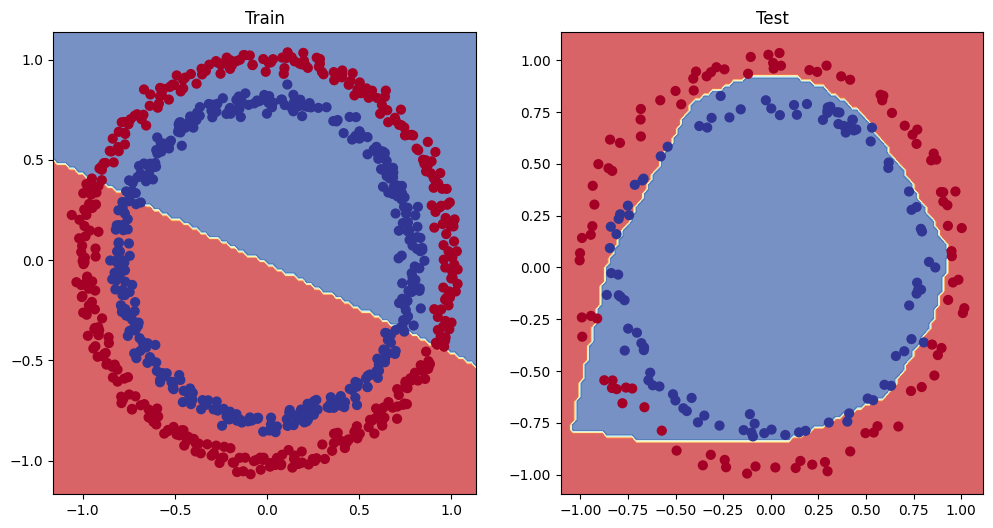

In [41]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

### creating a small amout of data to see what the non-linear model does

In [42]:
A = torch.arange(-10, 10, 1, dtype = torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

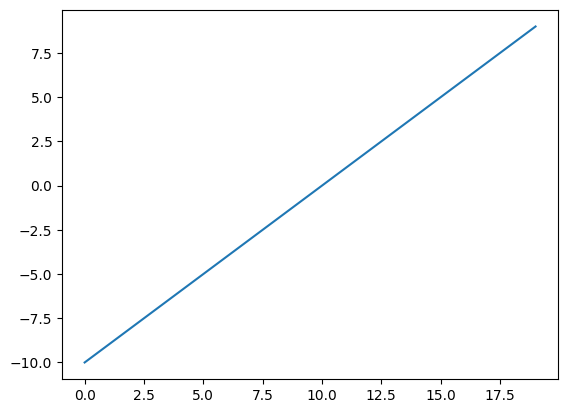

In [43]:
plt.plot(A)

### create ReLU function by hand

In [44]:
def relu(x):
  return torch.maximum(torch.tensor(0), x)

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

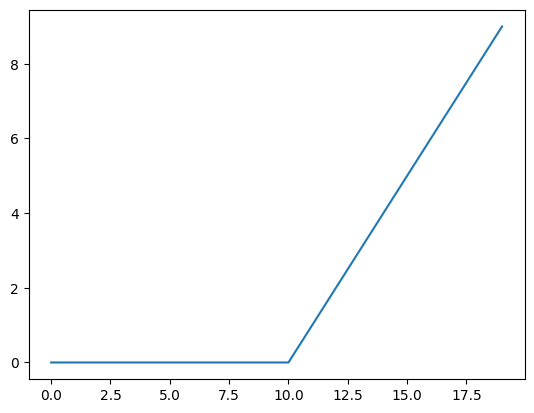

In [45]:
plt.plot(relu(A))

### create sigmoid function by hand

In [46]:
def sigmoid(x):
  return 1 / (1 + torch.exp(-x))

sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

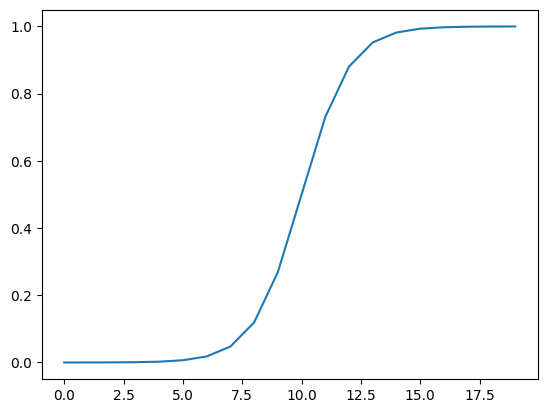

In [47]:
plt.plot(sigmoid(A))

### Creating mutli-class classification data

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


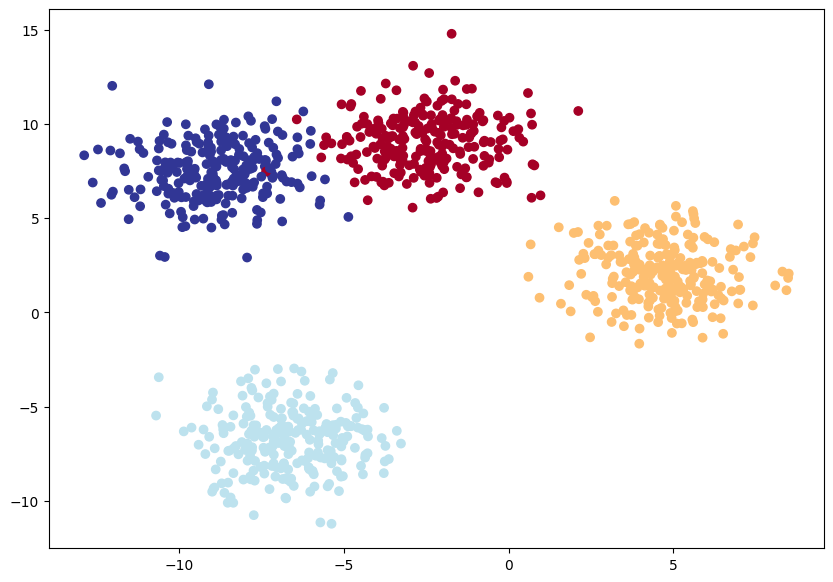

In [48]:
import torch
from matplotlib import pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

x_blob, y_blob = make_blobs(n_samples = 1000,
                            n_features = NUM_FEATURES, # X features
                            centers = NUM_CLASSES, # y labels
                            cluster_std=1.5,
                            random_state = RANDOM_SEED)

x_blob = torch.from_numpy(x_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

print(x_blob[:5], y_blob[:5])

x_blob_train, x_blob_test, y_blob_train, y_blob_test = train_test_split(x_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

plt.figure(figsize=(10, 7))
plt.scatter(x_blob[:, 0], x_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

### Building a model for multi-class data

In [49]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [50]:
from torch import nn

class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    super().__init__()

    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        # nn.ReLU()
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        # nn.ReLU()
        nn.Linear(in_features=hidden_units, out_features=output_features),
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

model_4 = BlobModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

### Creating optimizer and loss function for multi-class data

In [51]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), lr=0.1)

### single forward pass

In [52]:
model_4(x_blob_train.to(device))[:5]

tensor([[-1.2711, -0.6494, -1.4740, -0.7044],
        [ 0.2210, -1.5439,  0.0420,  1.1531],
        [ 2.8698,  0.9143,  3.3169,  1.4027],
        [ 1.9576,  0.3125,  2.2244,  1.1324],
        [ 0.5458, -1.2381,  0.4441,  1.1804]], device='cuda:0',
       grad_fn=<SliceBackward0>)

### Check how many elements per one prediction sample

In [53]:
model_4(x_blob_train.to(device))[0].shape, NUM_CLASSES

(torch.Size([4]), 4)

### converting logits into prediction probabilities using softmax function

In [54]:
y_logits = model_4(x_blob_test.to(device))
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[0.1872, 0.2918, 0.1495, 0.3715],
        [0.2824, 0.0149, 0.2881, 0.4147],
        [0.3380, 0.0778, 0.4854, 0.0989],
        [0.2118, 0.3246, 0.1889, 0.2748],
        [0.1945, 0.0598, 0.1506, 0.5951]], device='cuda:0',
       grad_fn=<SliceBackward0>)


In [55]:
torch.sum(y_pred_probs[0])

tensor(1., device='cuda:0', grad_fn=<SumBackward0>)

In [56]:
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.1872, 0.2918, 0.1495, 0.3715], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor(3, device='cuda:0')


### Training multi-class model

In [57]:
torch.manual_seed(42)
epochs = 100

x_blob_train, y_blob_train = x_blob_train.to(device), y_blob_train.to(device)
x_blob_test, y_blob_test = x_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
  ## Training
  model_4.train()

  # Forward pass
  y_logits = model_4(x_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  # Calculate loss and accuracy
  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy(y_true=y_blob_train,
                 y_pred=y_pred)

  # Zero gradients the optimizer
  optimizer.zero_grad()

  # Backword propagation on the loss
  loss.backward()

  # Step the optimizer
  optimizer.step()

  ## Testing
  model_4.eval()
  with torch.inference_mode():
    # Forward pass
    test_logits = model_4(x_blob_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

    # Calculate loss and accuracy
    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy(y_true=y_blob_test,
                        y_pred=test_pred)


    # Print what is happening
    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 1.04324, Acc: 65.50% | Test Loss: 0.57861, Test Acc: 95.50%
Epoch: 10 | Loss: 0.14398, Acc: 99.12% | Test Loss: 0.13037, Test Acc: 99.00%
Epoch: 20 | Loss: 0.08062, Acc: 99.12% | Test Loss: 0.07216, Test Acc: 99.50%
Epoch: 30 | Loss: 0.05924, Acc: 99.12% | Test Loss: 0.05133, Test Acc: 99.50%
Epoch: 40 | Loss: 0.04892, Acc: 99.00% | Test Loss: 0.04098, Test Acc: 99.50%
Epoch: 50 | Loss: 0.04295, Acc: 99.00% | Test Loss: 0.03486, Test Acc: 99.50%
Epoch: 60 | Loss: 0.03910, Acc: 99.00% | Test Loss: 0.03083, Test Acc: 99.50%
Epoch: 70 | Loss: 0.03643, Acc: 99.00% | Test Loss: 0.02799, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03448, Acc: 99.00% | Test Loss: 0.02587, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03300, Acc: 99.12% | Test Loss: 0.02423, Test Acc: 99.50%


### Making prediction with model_4

In [58]:
model_4.eval()
with torch.inference_mode():
  logits = model_4(x_blob_test)
logits[:5]

tensor([[  4.3377,  10.3539, -14.8948,  -9.7642],
        [  5.0142, -12.0371,   3.3860,  10.6699],
        [ -5.5885, -13.3448,  20.9894,  12.7711],
        [  1.8400,   7.5599,  -8.6016,  -6.9942],
        [  8.0726,   3.2906, -14.5998,  -3.6186]], device='cuda:0')

### Convert logits into predictions and comparing with the actual data

In [59]:
pred = torch.softmax(logits, dim=1).argmax(dim=1)

print(f"Predictions: {pred[:10]}")
print(f"Actual data: {y_blob_test[:10]}")
print(f"Accuracy: {accuracy(y_true=y_blob_test, y_pred=pred)}")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Actual data: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Accuracy: 99.5


### Visualize decision boundary

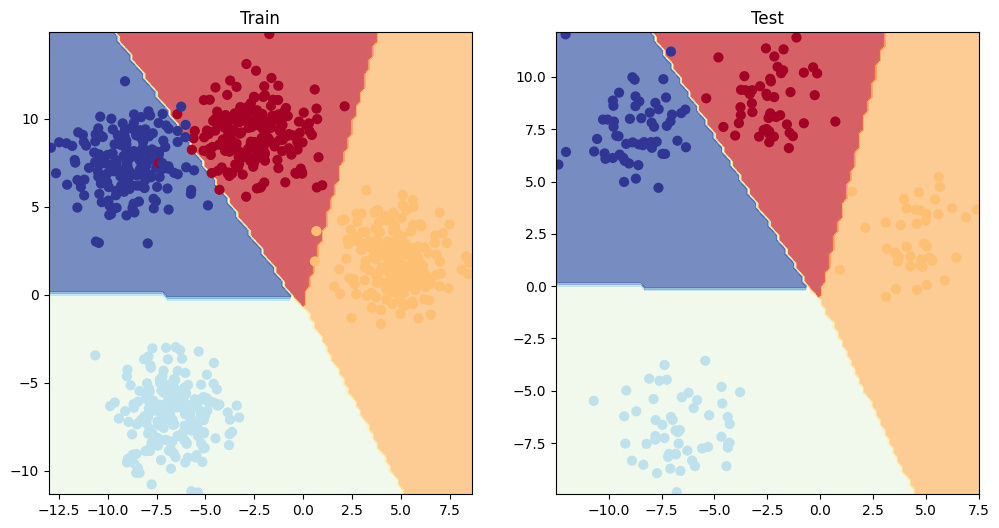

In [60]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, x_blob_train, y_blob_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, x_blob_test, y_blob_test)

### Evaluating multi-class model using extra function

In [64]:
try:
    from torchmetrics import Accuracy
except:
    !pip install torchmetrics==0.9.3 # this is the version we're using in this notebook (later versions exist here: https://torchmetrics.readthedocs.io/en/stable/generated/CHANGELOG.html#changelog)
    from torchmetrics import Accuracy

# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# Calculate accuracy
torchmetrics_accuracy(pred, y_blob_test)

tensor(0.9950, device='cuda:0')

## Exercises

### 1. Make a binary classification dataset with Scikit-Learn's make_moons() function.

    For consistency, the dataset should have 1000 samples and a random_state=42.
    Turn the data into PyTorch tensors. Split the data into training and test sets using train_test_split with 80% training and 20% testing.


In [65]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [66]:
from sklearn.datasets import make_moons

NUM_SAMPLES = 1000
RANDOM_SEED = 42

X, y = make_moons(n_samples = NUM_SAMPLES,
                  noise = 0.07,
                  random_state = RANDOM_SEED)

X[:10], y[:10]

(array([[-0.03341062,  0.4213911 ],
        [ 0.99882703, -0.4428903 ],
        [ 0.88959204, -0.32784256],
        [ 0.34195829, -0.41768975],
        [-0.83853099,  0.53237483],
        [ 0.59906425, -0.28977331],
        [ 0.29009023, -0.2046885 ],
        [-0.03826868,  0.45942924],
        [ 1.61377123, -0.2939697 ],
        [ 0.693337  ,  0.82781911]]),
 array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0]))

In [69]:
X, y = torch.tensor(X, dtype=torch.float), torch.tensor(y, dtype=torch.float)
# split the data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
len(X_train), len(X_test), len(y_train), len(y_test)

<ipython-input-69-b941ddfb3ba0>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X, y = torch.tensor(X, dtype=torch.float), torch.tensor(y, dtype=torch.float)


(800, 200, 800, 200)

### 2. Build a model by subclassing nn.Module that incorporates non-linear activation functions and is capable of fitting the data you created in 1.

    Feel free to use any combination of PyTorch layers (linear and non-linear) you want.


In [70]:
import torch
from torch import nn

class MoonModelV0(nn.Module):
  def __init__(self, input_features, output_features, hidden_units):
    super().__init__()
    self.layer_1 = nn.Linear(in_features = input_features, out_features = hidden_units)
    self.layer_2 = nn.Linear(in_features = hidden_units, out_features = hidden_units)
    self.layer_3 = nn.Linear(in_features = hidden_units, out_features = output_features)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.layer_3( self.relu(self.layer_2( self.relu(self.layer_1(x) ))) )

model_0 = MoonModelV0(input_features=2,
                      output_features=1,
                      hidden_units=10).to(device)
model_0

MoonModelV0(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

### 3. Setup a binary classification compatible loss function and optimizer to use when training the model.

In [71]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_0.parameters(), lr=0.1)

### 4. Create a training and testing loop to fit the model you created in 2 to the data you created in 1.

    To measure model accuray, you can create your own accuracy function or use the accuracy function in TorchMetrics.
    Train the model for long enough for it to reach over 96% accuracy.
    The training loop should output progress every 10 epochs of the model's training and test set loss and accuracy.


In [92]:
# put the data to device
X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)
model_0.to(device)
# logits
print(model_0(X_test)[:5].squeeze())

# probabilities
print(torch.sigmoid( model_0(X_test)[:5].squeeze() ))

# predictions
print(torch.round( torch.sigmoid( model_0(X_test)[:5].squeeze() ) ))

tensor([ 5.8707, -7.2655,  6.3570, -8.3796,  8.3979], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
tensor([9.9719e-01, 6.9876e-04, 9.9827e-01, 2.2945e-04, 9.9977e-01],
       device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([1., 0., 1., 0., 1.], device='cuda:0', grad_fn=<RoundBackward0>)


In [87]:
!pip -q install torchmetrics
from torchmetrics import Accuracy

acc_fn = Accuracy(multiclass=True, num_classes=2).to(device)
acc_fn

Accuracy()

In [88]:
## Training loop
epochs = 1000
torch.manual_seed(42)

for epoch in range(epochs):
  ## Train
  model_0.train()

  # Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred_probs = torch.sigmoid(y_logits)
  y_pred = torch.round(y_pred_probs)

  # Calculate loss and accuracy
  loss = loss_fn(y_logits, y_train)
  acc = acc_fn(y_pred, y_train.int())

  # Zero gradient the optimizer
  optimizer.zero_grad()

  # Backward propagation on the loss
  loss.backward()

  # Step the optimizer
  optimizer.step()

  ## Test
  model_0.eval()
  with torch.inference_mode():
    # Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round( torch.sigmoid(test_logits) )

    # Calculate loss and accuracy
    test_loss = loss_fn(test_logits, y_test)
    test_acc = acc_fn(test_pred, y_test.int())
  # Print out what's happening
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.2f} Acc: {acc:.2f} | Test loss: {test_loss:.2f} Test acc: {test_acc:.2f}")


Epoch: 0 | Loss: 0.70 Acc: 0.37 | Test loss: 0.69 Test acc: 0.50
Epoch: 100 | Loss: 0.39 Acc: 0.82 | Test loss: 0.40 Test acc: 0.76
Epoch: 200 | Loss: 0.24 Acc: 0.88 | Test loss: 0.24 Test acc: 0.89
Epoch: 300 | Loss: 0.20 Acc: 0.91 | Test loss: 0.19 Test acc: 0.94
Epoch: 400 | Loss: 0.17 Acc: 0.93 | Test loss: 0.15 Test acc: 0.94
Epoch: 500 | Loss: 0.12 Acc: 0.95 | Test loss: 0.11 Test acc: 0.96
Epoch: 600 | Loss: 0.08 Acc: 0.98 | Test loss: 0.07 Test acc: 0.99
Epoch: 700 | Loss: 0.06 Acc: 0.99 | Test loss: 0.05 Test acc: 1.00
Epoch: 800 | Loss: 0.04 Acc: 0.99 | Test loss: 0.03 Test acc: 1.00
Epoch: 900 | Loss: 0.03 Acc: 1.00 | Test loss: 0.02 Test acc: 1.00


### 5. Make predictions with your trained model and plot them using the plot_decision_boundary() function created in this notebook.

In [93]:
# Making prediction
with torch.inference_mode():
  logits = model_0(X_test)[:10].squeeze()
  pred = torch.round( torch.sigmoid(logits) )

pred, y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

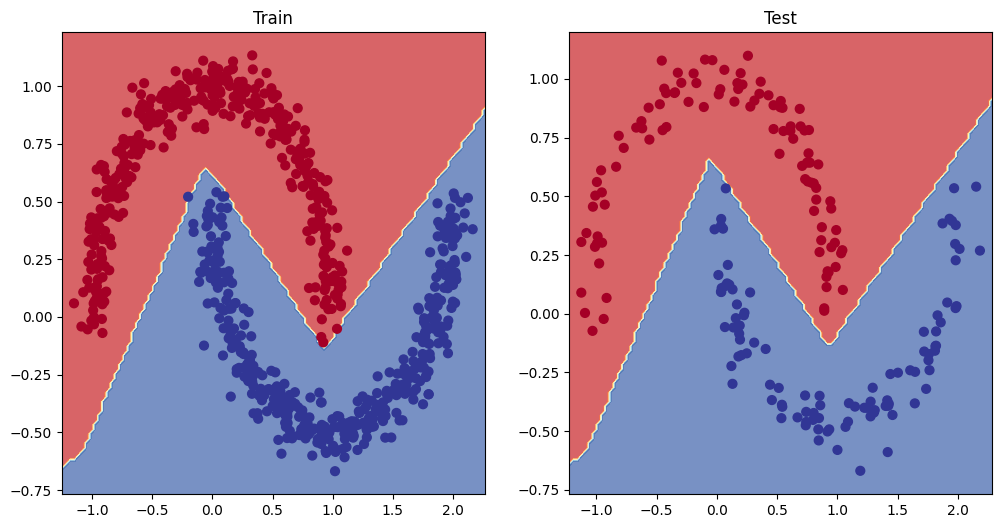

In [94]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)


### Replicate the Tanh (hyperbolic tangent) activation function in pure PyTorch.

    Feel free to reference the ML cheatsheet website for the formula.


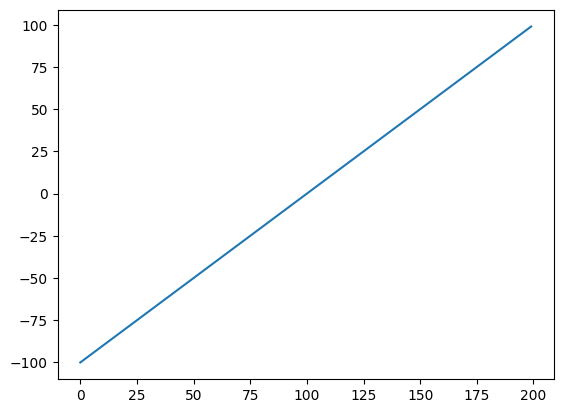

In [95]:
tensor_A = torch.arange(-100, 100, 1)
plt.plot(tensor_A)

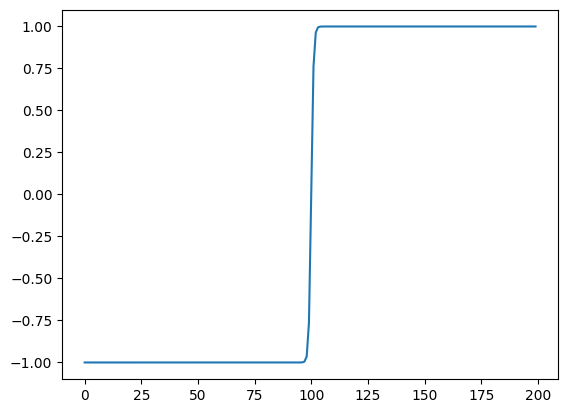

In [96]:
plt.plot(torch.tanh(tensor_A))

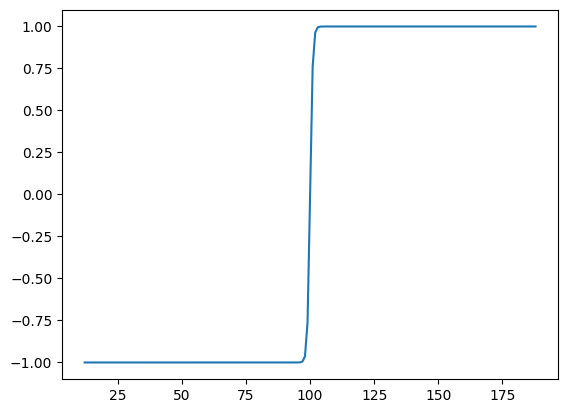

In [97]:
def tanh(x):
  return (torch.exp(x) - torch.exp(-x)) / (torch.exp(x) + torch.exp(-x))

plt.plot(tanh(tensor_A))

### 7. Create a multi-class dataset using the spirals data creation function from CS231n (see below for the code).

    Construct a model capable of fitting the data (you may need a combination of linear and non-linear layers).
    Build a loss function and optimizer capable of handling multi-class data (optional extension: use the Adam optimizer instead of SGD, you may have to experiment with different values of the learning rate to get it working).
    Make a training and testing loop for the multi-class data and train a model on it to reach over 95% testing accuracy (you can use any accuracy measuring function here that you like).
    Plot the decision boundaries on the spirals dataset from your model predictions, the plot_decision_boundary() function should work for this dataset too.


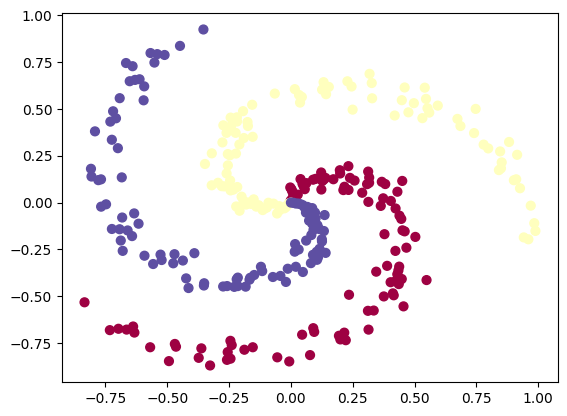

In [103]:
# Code for creating a spiral dataset from CS231n
import numpy as np
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [104]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float) # features as float32
y = torch.from_numpy(y).type(torch.LongTensor) # labels need to be of type long

# Create train and test splits
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
len(X_train), len(X_test), len(y_train), len(y_test)

(240, 60, 240, 60)

In [106]:

!pip -q install torchmetrics
from torchmetrics import Accuracy
acc_fn = Accuracy(task="multiclass", num_classes=3).to(device)
acc_fn

Accuracy()

In [107]:
device = "cuda" if torch.cuda.is_available() else "cpu"

class SpiralModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear1 = nn.Linear(in_features=2, out_features=10)
    self.linear2 = nn.Linear(in_features=10, out_features=10)
    self.linear3 = nn.Linear(in_features=10, out_features=3)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.linear3(self.relu(self.linear2(self.relu(self.linear1(x)))))

model_1 = SpiralModel().to(device)
model_1

SpiralModel(
  (linear1): Linear(in_features=2, out_features=10, bias=True)
  (linear2): Linear(in_features=10, out_features=10, bias=True)
  (linear3): Linear(in_features=10, out_features=3, bias=True)
  (relu): ReLU()
)

In [108]:

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
print(X_train.dtype, X_test.dtype, y_train.dtype, y_test.dtype)


print("Logits:")
print(model_1(X_train)[:10])

print("Pred probs:")
print(torch.softmax(model_1(X_train)[:10], dim=1))

print("Pred labels:")
print(torch.softmax(model_1(X_train)[:10], dim=1).argmax(dim=1))

torch.float32 torch.float32 torch.int64 torch.int64
Logits:
tensor([[-0.2150, -0.0589,  0.2273],
        [-0.2040, -0.0522,  0.2298],
        [-0.2229, -0.0609,  0.2383],
        [-0.2165, -0.0554,  0.2784],
        [-0.2205, -0.0520,  0.2797],
        [-0.2209, -0.0569,  0.2469],
        [-0.2193, -0.0574,  0.2422],
        [-0.2198, -0.0621,  0.2271],
        [-0.2070, -0.0528,  0.2315],
        [-0.2160, -0.0552,  0.2801]], device='cuda:0',
       grad_fn=<SliceBackward0>)
Pred probs:
tensor([[0.2684, 0.3138, 0.4178],
        [0.2698, 0.3140, 0.4163],
        [0.2658, 0.3126, 0.4216],
        [0.2621, 0.3079, 0.4300],
        [0.2609, 0.3088, 0.4303],
        [0.2649, 0.3121, 0.4229],
        [0.2658, 0.3125, 0.4217],
        [0.2678, 0.3135, 0.4187],
        [0.2690, 0.3139, 0.4171],
        [0.2620, 0.3077, 0.4303]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
Pred labels:
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')


In [111]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(),
                             lr=0.02)

In [112]:

epochs = 1000


for epoch in range(epochs):
  ## Training
  model_1.train()
  # 1. forward pass
  y_logits = model_1(X_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  # 2. calculate the loss
  loss = loss_fn(y_logits, y_train)
  acc = acc_fn(y_pred, y_train)

  # 3. optimizer zero grad
  optimizer.zero_grad()

  # 4. loss backwards
  loss.backward()

  # 5. optimizer step step step
  optimizer.step()

  ## Testing
  model_1.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_1(X_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
    # 2. Caculate loss and acc
    test_loss = loss_fn(test_logits, y_test)
    test_acc = acc_fn(test_pred, y_test)

  # Print out what's happening
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.2f} Acc: {acc:.2f} | Test loss: {test_loss:.2f} Test acc: {test_acc:.2f}")

Epoch: 0 | Loss: 1.12 Acc: 0.32 | Test loss: 1.10 Test acc: 0.37
Epoch: 100 | Loss: 0.43 Acc: 0.77 | Test loss: 0.51 Test acc: 0.70
Epoch: 200 | Loss: 0.13 Acc: 0.95 | Test loss: 0.17 Test acc: 0.95
Epoch: 300 | Loss: 0.07 Acc: 0.99 | Test loss: 0.04 Test acc: 1.00
Epoch: 400 | Loss: 0.05 Acc: 0.98 | Test loss: 0.02 Test acc: 1.00
Epoch: 500 | Loss: 0.04 Acc: 0.99 | Test loss: 0.02 Test acc: 1.00
Epoch: 600 | Loss: 0.03 Acc: 0.99 | Test loss: 0.04 Test acc: 0.98
Epoch: 700 | Loss: 0.03 Acc: 0.99 | Test loss: 0.01 Test acc: 1.00
Epoch: 800 | Loss: 0.02 Acc: 0.99 | Test loss: 0.01 Test acc: 1.00
Epoch: 900 | Loss: 0.02 Acc: 0.99 | Test loss: 0.00 Test acc: 1.00


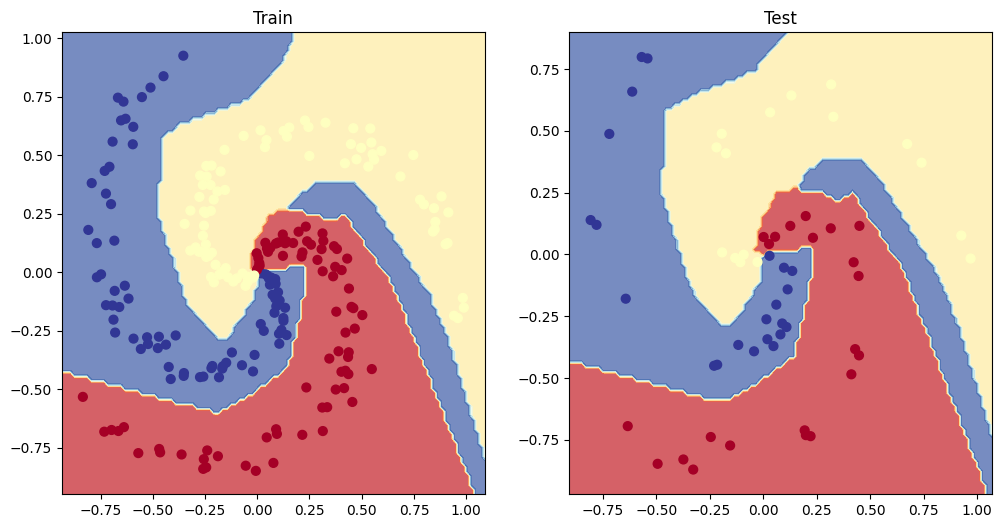

In [113]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)